# 0. Introduction

We are going to use the data that we have been provided to study and try to predict the evolution of Dengue disease in the cities of **San Jose**, *Puerto Rico*, and **Iquitos**, *Peru*. More information in this [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

In this notebook, the AdamBost algorithm studied in the baseline will be optimized, with the aim of finding the best parameterization of this algorithm, with the aim of continuing to search for better models.




# 1. Libraries

Before starting any analysis we must ensure that the basic and general use libraries *(numpy, pandas, etc.)* are correctly imported. 

In [ ]:
# Preprocessing
from sklearn import preprocessing

# Loading the data
import pandas as pd
import io
from google.colab import files

# Graphics display
import seaborn as sns
import matplotlib.pyplot as plt

# Estimator and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor

# Others
import numpy as np    
from sklearn.metrics import mean_absolute_error 

# 2. Loading the data

The first step is to upload all the CSV files that have been provided to us and that thanks to them we will obtain the data with which we are going to work. To do this, we will use the tools that Google Colab offers us when uploading files.

## Preprocessing the data

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, etc.

In [ ]:
# Make function to preprocess data
def preprocess_data(data_path, labels_path=None):
    # Load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path)
    # Fill missing values
    df.fillna(df.mean(), inplace=True)
    lb = preprocessing.LabelBinarizer()
    
    if labels_path:
        labels = pd.read_csv(labels_path)
        
        labels['city'] = lb.fit_transform(labels['city'])
    
    df['city'] =  lb.fit_transform(df['city'])

    ## Coger variables, a la parte de mejoras. Esto se debe de borrar.
    selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']
    df = df[selected_features]

    if labels_path:
        return df, labels
    return df

We execute the newly compiled method, which will allow us to load and preprocess our data.

In [ ]:
df_features, df_labels = preprocess_data('dengue_features_train.csv', labels_path="dengue_labels_train.csv")

Finally, we also load the file with which we will carry out the final prediction, once our model is trained.

In [ ]:
df_test_final = preprocess_data("dengue_features_test.csv")

# 3. Detaching the dataset

To train the models that we make, it is necessary to separate our training dataset into two parts, one precisely to train the model, and another to check if our models are good.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels['total_cases'], test_size=0.2, random_state=1)

# 4. Hyperparameter optimization

Previously, in the baseline, we have created models with simple optimization. That is, we have only created models with a combination of parameters. However, now, thanks to the *GridSearchCV* and *RandomizedSearchCV* functions, we will be able to combine different values for the parameters of the estimators, so that it returns us the best possible model.

The estimator with which we are going to work in the optimization is the following.

In [ ]:
est = AdaBoostRegressor()

## Grid Search

Grind Search generates candidates from a grid of parameter values specified with the param_grid parameter.

In [ ]:
# We declare the variables to be hyperparameterized
param = [{'n_estimators': [50,100,150,200,250,300,450,500,550,600,650,700,750]}]

# Initialize the grid search
grid = GridSearchCV(estimator = est, param_grid = param, cv = 5)

# Train our model
grid.fit(X_train,y_train)

# We show the results
print("Mejores parámetros: ")
print(grid.best_params_)
print()
print("Puntuaciones: ")
print(grid.cv_results_['mean_test_score'])

Mejores parámetros: 
{'n_estimators': 200}

Puntuaciones: 
[-1.08166796 -0.35194808 -0.52198921 -0.18205959 -0.18961107 -0.6039089
 -0.24377067 -0.42242286 -0.57622842 -0.55560231 -0.34653872 -0.57063852
 -0.41841947]


Now, we predict with the estimator with the best parameters.

In [ ]:
y_grid = grid.predict(X_test)

MAE 21.030451771278514


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


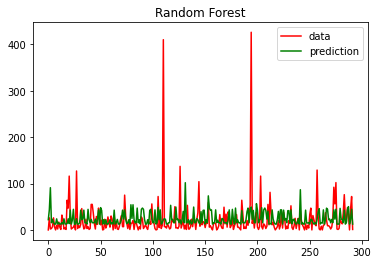

In [ ]:
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_grid, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("AdaBoost Regressor")

plt.show()

mae = mean_absolute_error(y_test, y_grid)
print ('MAE', mae)


### Submision Result

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.

In [ ]:
final_model_prediction = grid.predict(df_test_final)

# round the result and cast to int
y = np.rint(final_model_prediction) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 16,  23,  23,  48,  45,  49,  44,  43,  43,  43,  48,  44,  43,
        43,  49,  44,  43,  54,  88,  53,  49,  23,  22,  43,  23,  42,
        48,  43,  43,  44,  24,  16,  23,  16,  16,  22,  16,  23,  16,
        16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  24,  23,
        23,  23,  44,  24,  42,  46,  49,  43,  49,  46,  43,  46,  44,
        44,  46,  43,  44,  51,  44,  43,  43,  43,  51,  51,  57,  43,
        43,  49,  23,  42,  39,  44,  44,  24,  24,  22,  16,  16,  16,
        24,  16,  16,  16,  23,  23,  16,  16,  22,  45,  23,  16,  24,
        42,  23,  44,  43,  43, 102,  55,  44,  45,  50, 102,  97,  53,
        23,  54,  88,  54,  87,  89,  97,  87,  48,  44,  49,  80,  43,
        49,  23,  39,  24,  23,  16,  16,  24,  16,  23,  16,  16,  16,
        16,  16,  16,  23,  16,  16,  16,  16,  16,  16,  13,  16,  23,
        24,  25,  24,  15,  16,  40,  16,  25,  23,  23,  53,  53,  23,
        77,  44,  25,  53, 102,  23,  43,  55,  24,  54,  54,  4

We build the output file

In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = final_model_prediction.astype(np.int64)
submission.to_csv("result_grid.csv")

**And the result is:**

*------
Woo! I scored ----- on 'DengAI: Predicting Disease Spread'!*

## Randomized Search

Randomized Search can sample a given number of candidates from a parameter space with a specified distribution.


In [ ]:
# We declare the variables to be hyperparameterized
param = [{'n_estimators': [50,100,150,200,250,300,450,500,550,600,650,700,750]}]

# Initialize the grid search
random = RandomizedSearchCV(estimator = est, param_distributions = param, cv = 5)

# Train our model
random.fit(X_train,y_train)

# We show the results
print("Mejores parámetros: ")
print(grid.best_params_)
print()
print("Puntuaciones: ")
print(grid.cv_results_['mean_test_score'])

Mejores parámetros: 
{'max_depth': 2, 'n_estimators': 50}

Puntuaciones: 
[ 0.10523024  0.10322747  0.10153094  0.09857688  0.10055871  0.09826032
  0.0998078   0.09982301  0.10034248  0.09967821  0.0980637   0.09899248
  0.09984952  0.06443714  0.08191204  0.07052295  0.07765943  0.07320428
  0.07156184  0.06939422  0.07526501  0.07229545  0.07844626  0.07378295
  0.07318999  0.07255605  0.0094095   0.01403499 -0.00205863  0.01413613
 -0.00314057  0.01217256  0.00236548  0.01055646  0.00600914  0.0155698
  0.00317629  0.00510009  0.00701806 -0.07403429 -0.06362895 -0.07121264
 -0.07408757 -0.06198078 -0.05743031 -0.07132763 -0.05694915 -0.05050929
 -0.04989884 -0.05323741 -0.06296979 -0.04603837 -0.12366978 -0.07881381
 -0.09315589 -0.08793365 -0.09790385 -0.10451023 -0.08270541 -0.09107812
 -0.10270959 -0.08424067 -0.08569773 -0.09130316 -0.08400328 -0.12136425
 -0.09403718 -0.11386873 -0.12191449 -0.11553426 -0.11247695 -0.09629807
 -0.11599129 -0.11176387 -0.10075207 -0.10715452 -0

Now, we predict with the estimator with the best parameters.

In [ ]:
y_random = random.predict(X_test)

MAE 21.20947268004697


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


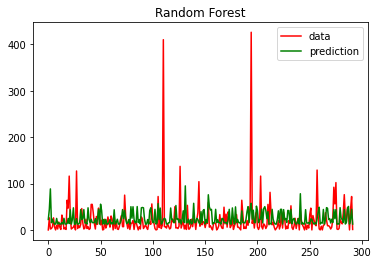

In [ ]:
mae = mean_absolute_error(y_test, y_random)
print ('MAE', mae)

xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_random, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("AdaBoost Regressor")

plt.show()

### Submision Result

Once the best parameterization has been identified, we will carry out an execution of the model to make a prediction of the weeks that are proposed to us, and we will graph its results.

In [ ]:
final_model_prediction = grid.predict(df_test_final)

# Round the result and cast to int
y = np.rint(final_model_prediction)
y = y.astype(int)
res = np.hstack(y)

res

array([ 16,  23,  23,  48,  45,  49,  44,  43,  43,  43,  48,  44,  43,
        43,  49,  44,  43,  54,  88,  53,  49,  23,  22,  43,  23,  42,
        48,  43,  43,  44,  24,  16,  23,  16,  16,  22,  16,  23,  16,
        16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  24,  23,
        23,  23,  44,  24,  42,  46,  49,  43,  49,  46,  43,  46,  44,
        44,  46,  43,  44,  51,  44,  43,  43,  43,  51,  51,  57,  43,
        43,  49,  23,  42,  39,  44,  44,  24,  24,  22,  16,  16,  16,
        24,  16,  16,  16,  23,  23,  16,  16,  22,  45,  23,  16,  24,
        42,  23,  44,  43,  43, 102,  55,  44,  45,  50, 102,  97,  53,
        23,  54,  88,  54,  87,  89,  97,  87,  48,  44,  49,  80,  43,
        49,  23,  39,  24,  23,  16,  16,  24,  16,  23,  16,  16,  16,
        16,  16,  16,  23,  16,  16,  16,  16,  16,  16,  13,  16,  23,
        24,  25,  24,  15,  16,  40,  16,  25,  23,  23,  53,  53,  23,
        77,  44,  25,  53, 102,  23,  43,  55,  24,  54,  54,  4

We build the output file

In [ ]:
submission = pd.read_csv("submission_format.csv",index_col=[0, 1, 2])

submission.total_cases = final_model_prediction.astype(np.int64)
submission.to_csv("result_randomized.csv")

**And the result is:**

*------
Woo! I scored ----- on 'DengAI: Predicting Disease Spread'!*

# 5. Conclusions

Cuando tengamos alguna, comparandolo con los de la linea base.